## The Bias/Variance Trade-off

An important theoretical result of statistics and Machine Learning is the fact that a model’s generalization error can be expressed as the sum of three very different errors:
### Bias
This part of the generalization error is due to wrong assumptions, such as assuming that the data is linear when it is actually quadratic. A high-bias model is most likely to underfit the training data.
### Variance: 
This part is due to the model’s excessive sensitivity to small variations in the training data. A model with many degrees of freedom(such as a high-degree polynomial model) is likely to have high variance and thus overfit the training data.
### Irreducible error: 
This part is due to the noisiness of the data itself. The only way to reduce this part of the error is to clean up the data (e.g., fix the data sources, such as broken sensors, or detect and remove outliers).
Increasing a model’s complexity will typically increase its variance and reduce its bias. Conversely, reducing a model’s complexity increases its bias and reduces its variance. This is why it is called a trade-off.

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import clone
%matplotlib notebook

In [ ]:
# Get dataset
dataset_cat = '../data/ready/properties.csv'

properties = pd.read_csv(dataset_cat)
properties = properties[properties['price'] < 8e5]

In [3]:
# split dataset in train and test
X_train, X_test, y_train, y_test = train_test_split(properties.drop('price', axis=1),
                                                    properties['price'],
                                                    test_size=0.2,
                                                    random_state=0
                                                   )

In [6]:
drop_features = [
    'year',
]
numeric_features = [
    'bathrooms', 
    'bedrooms',
    'garage',
    'servide_fees',
    'surface_balcony',
    'surface_covered',
    'floor',
    'm2_index',
    'decade',
]
binary_features = [
    'floor_special',
    'facilities',
    'near_river',
    'is_house',
    'barbecue',
]
categorical_features = [
    'zone',
    'orientation',
    'state',
]

In [10]:
numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
    ])

categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(categories='auto', handle_unknown='ignore')),
    ])

preprocessor_num = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('drop', 'drop', drop_features + categorical_features),
        ('passthrough', 'passthrough', binary_features),
    ],
    n_jobs=-1)

preprocessor_cat = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('drop', 'drop', drop_features),
        ('passthrough', 'passthrough', binary_features),
    ],
    n_jobs=-1)

In [138]:
def partial_train(predictor, X_train, X_test, y_train, y_test, scoring='rmse'):
    model_reg = Pipeline(steps=[('preprocessor', preprocessor_cat),
                      ('linear_regressor', clone(predictor))])
    model_reg.fit(X_train, y_train)
    y_pred_train = model_reg.predict(X_train)
    y_pred_test = model_reg.predict(X_test)
    if performance == 'rmse':
        error_train = np.sqrt(mse(y_train, y_pred_train))
        error_test = np.sqrt(mse(y_test, y_pred_test))
    elif performance == 'r2':
        error_train = r2_score(y_train, y_pred_train)
        error_test = r2_score(y_test, y_pred_test)
    else:
        error_train = np.sqrt(mse(y_train, y_pred_train))
        error_test = np.sqrt(mse(y_test, y_pred_test))
    
    return error_train, error_test

def learning_curves(predictor, X_train, X_test, y_train, y_test, step=1000, scoring='rmse'):
    scores = [partial_train(predictor,
                            X_train.iloc[:k, :],
                            X_test,
                            y_train.iloc[:k],
                            y_test,
                            performance, )
              for k in range(2, X_train.shape[0], step)]

    df = pd.DataFrame(scores, columns=['train', 'test'], index=range(2, X_train.shape[0], step))
    
    return df

def plot_learning_curves(df, **kwargs):
    ops = {
        'xlabel': 'samples',
        'ylabel': 'performance',
        **kwargs}
    f, ax = plt.subplots()
    df.plot(ax=ax)
    ax.grid()
    ax.set(**ops)
    return f, ax

# Learning curves

## Linear Regression

<IPython.core.display.Javascript object>


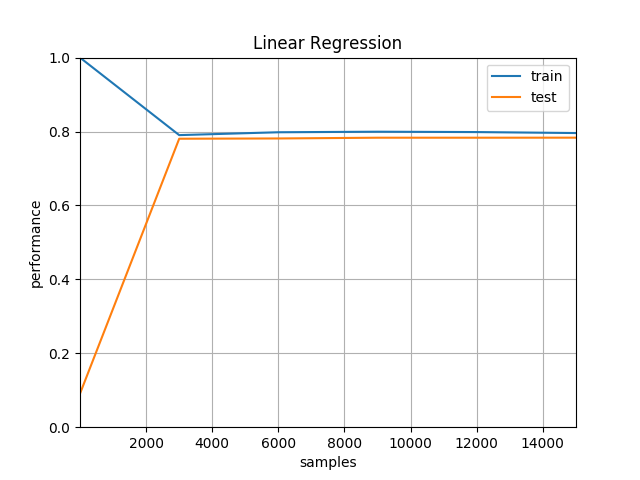

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff1b48c7a90>)

In [139]:
lr_reg = LinearRegression(fit_intercept=True)
df_lr = learning_curves(lr_reg, X_train, X_test, y_train, y_test, step=3000, scoring='r2') 
plot_learning_curves(df_lr, title='Linear Regression', ylim=[0, 1])

## Random Forest 

<IPython.core.display.Javascript object>


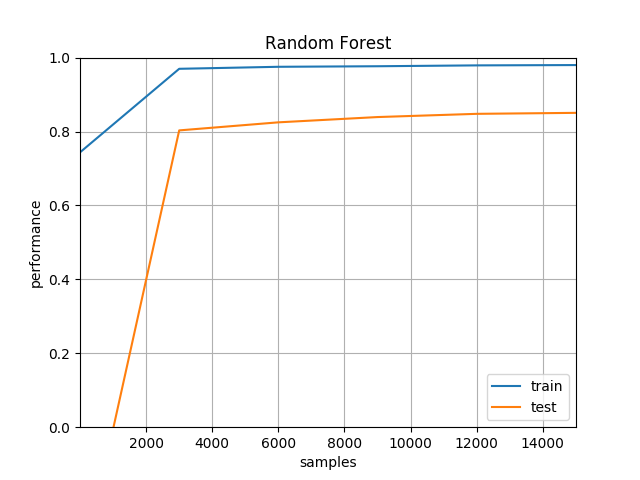

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff1b7d0beb8>)

In [140]:
rf_reg = RandomForestRegressor(n_estimators=100, n_jobs=-1)
df_rf = learning_curves(rf_reg, X_train, X_test, y_train, y_test, step=3000, scoring='r2') 
plot_learning_curves(df_rf, title='Random Forest', ylim=[0, 1])

## Random Forest with regularization

<IPython.core.display.Javascript object>


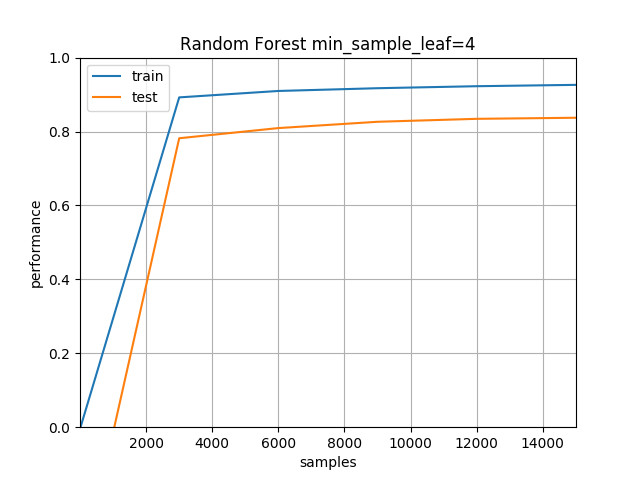

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff1b7c82668>)

In [141]:
rf_reg = RandomForestRegressor(n_estimators=100, min_samples_leaf=4, n_jobs=-1)
df_rf = learning_curves(rf_reg, X_train, X_test, y_train, y_test, step=3000, scoring='r2') 
plot_learning_curves(df_rf, title='Random Forest min_sample_leaf=4', ylim=[0, 1])

# References
- Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow. (2019) Aurélien Géron